In [1]:
import pandas as pd
from pathlib import Path
import sys
import json
import ast
import numpy as np
import sys
from pathlib import Path

# notebook location
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))
print("Added to path:", project_root)

#sys.path.append(r"C:\Users\giusy\OneDrive\Desktop\PAPERS\2026_Sensors_speech\SilentWear")
from utils.I_data_preparation.experimental_config import ORIGINAL_LABELS
from utils.I_data_preparation.read_mat_file import MAT_LABLES
from utils.III_results_analysis.utils import *

Added to path: /home/gspacone/Desktop/SilentWear


# Compare Subject Global Models

In [20]:
############### CHANGE HERE
models_dire = Path(r"/scratch2/gspacone/sensors_2026_final/models/global")
subjects_to_consider = ["S00"]
conditions_to_consider = ["silent", "vocalized"]

In [ ]:

all_rows = []

for subject in subjects_to_consider:
    for condition in conditions_to_consider:
        subject_folder_path = models_dire / subject / condition
        print(subject_folder_path)
        if not subject_folder_path.exists():
            continue

        for model_folder in subject_folder_path.iterdir():
            if not model_folder.is_dir():
                continue
            print(model_folder)
            model_runs = [p for p in model_folder.iterdir() if p.is_dir()]
            print("Model type:", model_folder.name, "contains", len(model_runs), "variants")

            for curr_model_folder in model_runs:
                run_cfg_file = curr_model_folder / "run_cfg.json"
                if not run_cfg_file.exists():
                    continue

                with open(run_cfg_file, "r", encoding="utf-8") as f:
                    run_cfg = json.load(f)

                include_rest = run_cfg["experimental_settings"]["include_rest"]
                print("include_rest was", include_rest)
                original_label_map = ORIGINAL_LABELS.copy() if subject != "S00" else MAT_LABLES.copy()

                # training labels (keep if you need label order)

                # note, breaks for S00
                train_label_map, train_to_orig, orig_to_train = generate_training_labels(
                    include_rest=include_rest,
                    original_label_map=original_label_map
                )

                cv_path = curr_model_folder / "cv_summary.csv"
                if not cv_path.exists():
                    continue
                model_summary_file = pd.read_csv(cv_path)

                mean_cm, std_cm = mean_std_confusion_matrices(model_summary_file["confusion_matrix"])

                # config signature for "exactly same run cfg" comparison
                sig_full = cfg_signature(run_cfg['model_cfg'], drop_keys=set())                 # truly exact
                if run_cfg.get("seeds") is not None:
                    sig_seeds = cfg_signature(run_cfg["seeds"], drop_keys=set())
                else:
                    sig_seeds = "default"

                #sig_stable = cfg_signature(run_cfg, drop_keys=VOLATILE_KEYS)       # ignore volatile

                row = {
                    "subject": subject,
                    "condition": run_cfg.get("condition", condition),
                    "model_type_folder": model_folder.name,
                    "model_name": run_cfg["model_cfg"]["model"]["name"],
                    "include_rest": include_rest,

                    "balanced_acc_mean": float(model_summary_file["balanced_accuracy"].mean()),
                    "balanced_acc_std": float(model_summary_file["balanced_accuracy"].std()),

                    "mean_cm": None if mean_cm is None else mean_cm.tolist(),
                    "std_cm": None if std_cm is None else std_cm.tolist(),

                    "run_cfg_signature_exact": sig_full,

                    "run_cfg_signature_seeds": sig_seeds,
                    "run_path": str(curr_model_folder),
                    "run_cfg": run_cfg,  # keep full config for inspection
                    "train_label_map" : train_label_map,

                    "win_size_ms": run_cfg['experimental_settings']['window_size_ms']
                }

                all_rows.append(row)

summary_df = pd.DataFrame(all_rows)


/scratch2/gspacone/sensors_2026_final/models/global/S00/silent
/scratch2/gspacone/sensors_2026_final/models/global/S00/silent/random_forest
Model type: random_forest contains 1 variants
include_rest was False
/scratch2/gspacone/sensors_2026_final/models/global/S00/vocalized
/scratch2/gspacone/sensors_2026_final/models/global/S00/vocalized/random_forest
Model type: random_forest contains 1 variants
include_rest was False


In [24]:
summary_df["train_label_map"].iloc[0]

{0: 'rest',
 1: 'left',
 2: 'right',
 3: 'up',
 4: 'down',
 5: 'forward',
 6: 'backward',
 7: 'stop',
 8: 'go'}

RANDOM FOREST | WIN_1400S


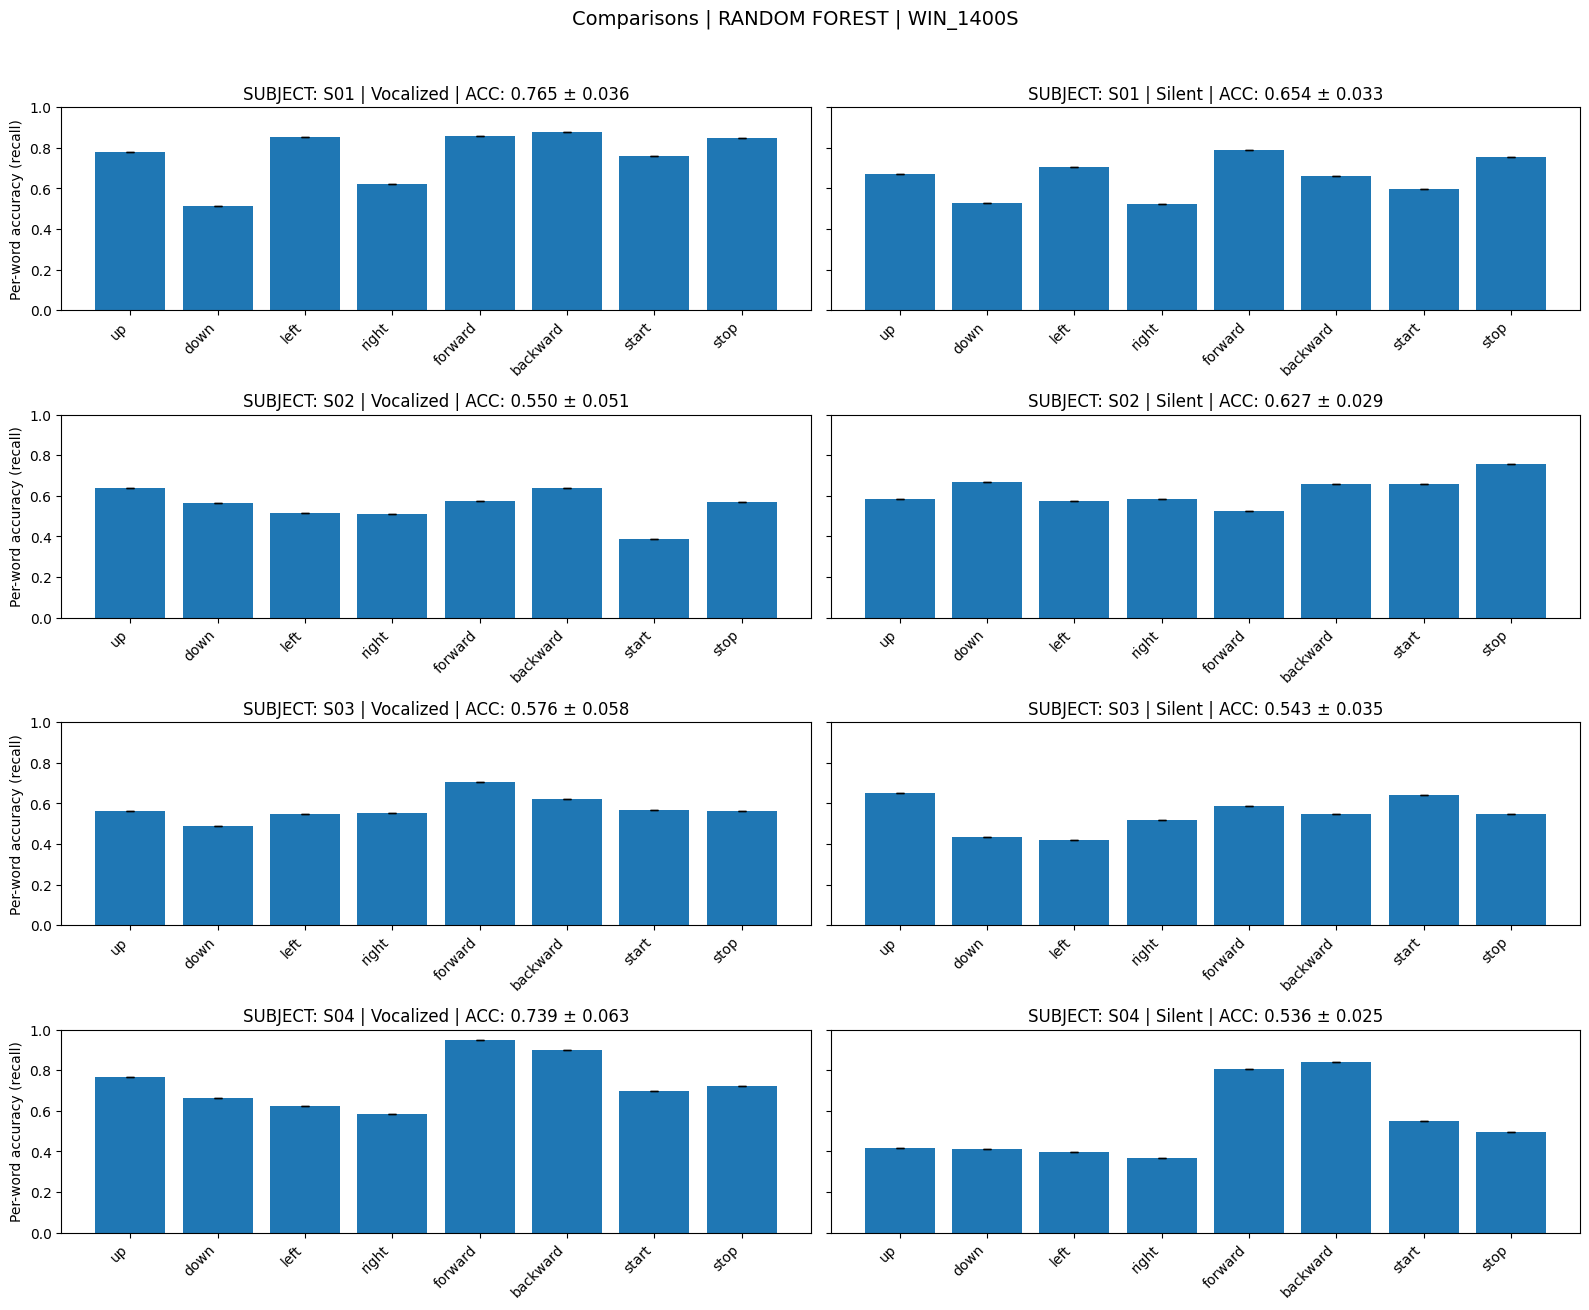

In [29]:
model_to_select = 'random_forest'

model_df = summary_df[summary_df['model_name'] == model_to_select]
model_win = model_df[model_df['win_size_ms']==1400]
plot_subject_word_accuracy_grid_from_summary(model_win, "vocalized", "silent", title_extras="RANDOM FOREST | WIN_1400S")

In [30]:
silent_accs = model_win[model_win['condition'] == 'silent']['balanced_acc_mean'].values
print(f"Silent ACC | avg across subjects: {np.mean(silent_accs):.2f} ± {np.std(silent_accs):.2f}")
vocalized_accs = model_win[model_win['condition'] == 'vocalized']['balanced_acc_mean'].values
print(f"Vocalized ACC | avg across subjects: {np.mean(vocalized_accs):.2f} ± {np.std(vocalized_accs):.2f}")

Silent ACC | avg across subjects: 0.59 ± 0.05
Vocalized ACC | avg across subjects: 0.66 ± 0.10


In [31]:
model_to_select = 'speechnet_base'
model_df = summary_df[summary_df["model_name"] == model_to_select]

# Models sharing the same architecture
dfs_shared = {
    sig: group
    for sig, group in model_df.groupby("run_cfg_signature_exact")
    if len(group) > 1
}

for key_id in range(len(dfs_shared.keys())):
    curr_key = list(dfs_shared.keys())[key_id]
    curr_df = dfs_shared[curr_key]


    # check if we need to further split by seeds
    seed_sigs = list(curr_df["run_cfg_signature_seeds"].unique())
    
    for sig_seed_id in range(len(seed_sigs)):

        model_seed_df = curr_df[curr_df["run_cfg_signature_seeds"] == seed_sigs[sig_seed_id]]

        print(f"Model variant {key_id} | seed variant {sig_seed_id} | seed sig: {seed_sigs[sig_seed_id]}")
        print("Seeds set to:", model_seed_df["run_cfg"].iloc[0].get("seeds", "default"))
        model_win = model_seed_df[model_seed_df['win_size_ms']==1400]


        silent_accs = model_win[model_win['condition'] == 'silent']['balanced_acc_mean'].values
        print(f"Silent ACC | avg across subjects: {np.mean(silent_accs):.2f} ± {np.std(silent_accs):.2f}")
        vocalized_accs = model_win[model_win['condition'] == 'vocalized']['balanced_acc_mean'].values
        print(f"Vocalized ACC | avg across subjects: {np.mean(vocalized_accs):.2f} ± {np.std(vocalized_accs):.2f}")


        blocks_config = model_win["run_cfg"].iloc[0]["model_cfg"]["model"]["kwargs"]['blocks_config']
        for curr_block in blocks_config:
            print(curr_block)
        print("\n\n")

Model variant 0 | seed variant 0 | seed sig: default
Seeds set to: default
Silent ACC | avg across subjects: 0.69 ± 0.07
Vocalized ACC | avg across subjects: 0.81 ± 0.06
{'kernel': [1, 4], 'out_channels': 8, 'pool': [1, 8]}
{'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': ['full', 1], 'out_channels': 32, 'pool': [1, 1]}
{'kernel': [1, 1], 'out_channels': 32, 'pool': [1, 1]}



Model variant 1 | seed variant 0 | seed sig: d1cc30d405496f11b7486e493a26acd2a9d1d64a51f1e80a149918343b27a262
Seeds set to: {'random_seed': 20, 'rgn_seed': 62, 'torch_manual_seed': 62}
Silent ACC | avg across subjects: 0.68 ± 0.06
Vocalized ACC | avg across subjects: 0.79 ± 0.05
{'kernel': [1, 4], 'out_channels': 8, 'pool': [1, 8]}
{'kernel': [1, 16], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': [1, 8], 'out_channels': 16, 'pool': [1, 4]}
{'kernel': [7, 1], 'out_channels': 32, 'pool': [1, 1]}
{'kernel': [7, 1], 'out_channels': 32, 'pool': 

In [37]:
curr_df

,subject,condition,model_type_folder,model_name,include_rest,balanced_acc_mean,balanced_acc_std,mean_cm,std_cm,run_cfg_signature_exact,run_cfg_signature_seeds,run_path,run_cfg,train_label_map,win_size_ms
1,S01,silent,speechnet_base_tmp,speechnet_base,False,0.705000,0.040547,"[[0.6366666666666667, 0.08666666666666667, 0.1...","[[0.18660713336371207, 0.05312459150169742, 0....",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
8,S01,vocalized,speechnet_base_tmp,speechnet_base,False,0.815833,0.046412,"[[0.82, 0.013333333333333332, 0.09666666666666...","[[0.054160256030906406, 0.012472191289246471, ...",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
15,S02,silent,speechnet_base_tmp,speechnet_base,False,0.673333,0.037914,"[[0.6866666666666668, 0.04666666666666667, 0.0...","[[0.10821788720498617, 0.026666666666666665, 0...",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
22,S02,vocalized,speechnet_base_tmp,speechnet_base,False,0.657500,0.053635,"[[0.72, 0.013333333333333332, 0.18, 0.01333333...","[[0.19871811414385174, 0.026666666666666665, 0...",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
29,S03,silent,speechnet_base_tmp,speechnet_base,False,0.590833,0.063287,"[[0.5833333333333334, 0.07666666666666666, 0.2...","[[0.12110601416389967, 0.04422166387140533, 0....",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
36,S03,vocalized,speechnet_base_tmp,speechnet_base,False,0.699167,0.063935,"[[0.6066666666666667, 0.09, 0.1666666666666666...","[[0.11999999999999998, 0.05120763831912405, 0....",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
43,S04,silent,speechnet_base_tmp,speechnet_base,False,0.549583,0.066803,"[[0.22000000000000003, 0.11000000000000001, 0....","[[0.13719410418171119, 0.07498147919467994, 0....",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'silent', 'cv': {'m...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400
50,S04,vocalized,speechnet_base_tmp,speechnet_base,False,0.810417,0.045021,"[[0.8733333333333333, 0.03333333333333334, 0.0...","[[0.09225568335398698, 0.029814239699997195, 0...",de8ef09aa57a2beff4ae3e5cd8e54219f052787d5b494c...,default,/scratch2/gspacone/sensors_2026_speech_models/...,"{'base_cfg': {'condition': 'vocalized', 'cv': ...","{0: 'up', 1: 'down', 2: 'left', 3: 'right', 4:...",1400


SPEECH NET BASE | WIN_1400S


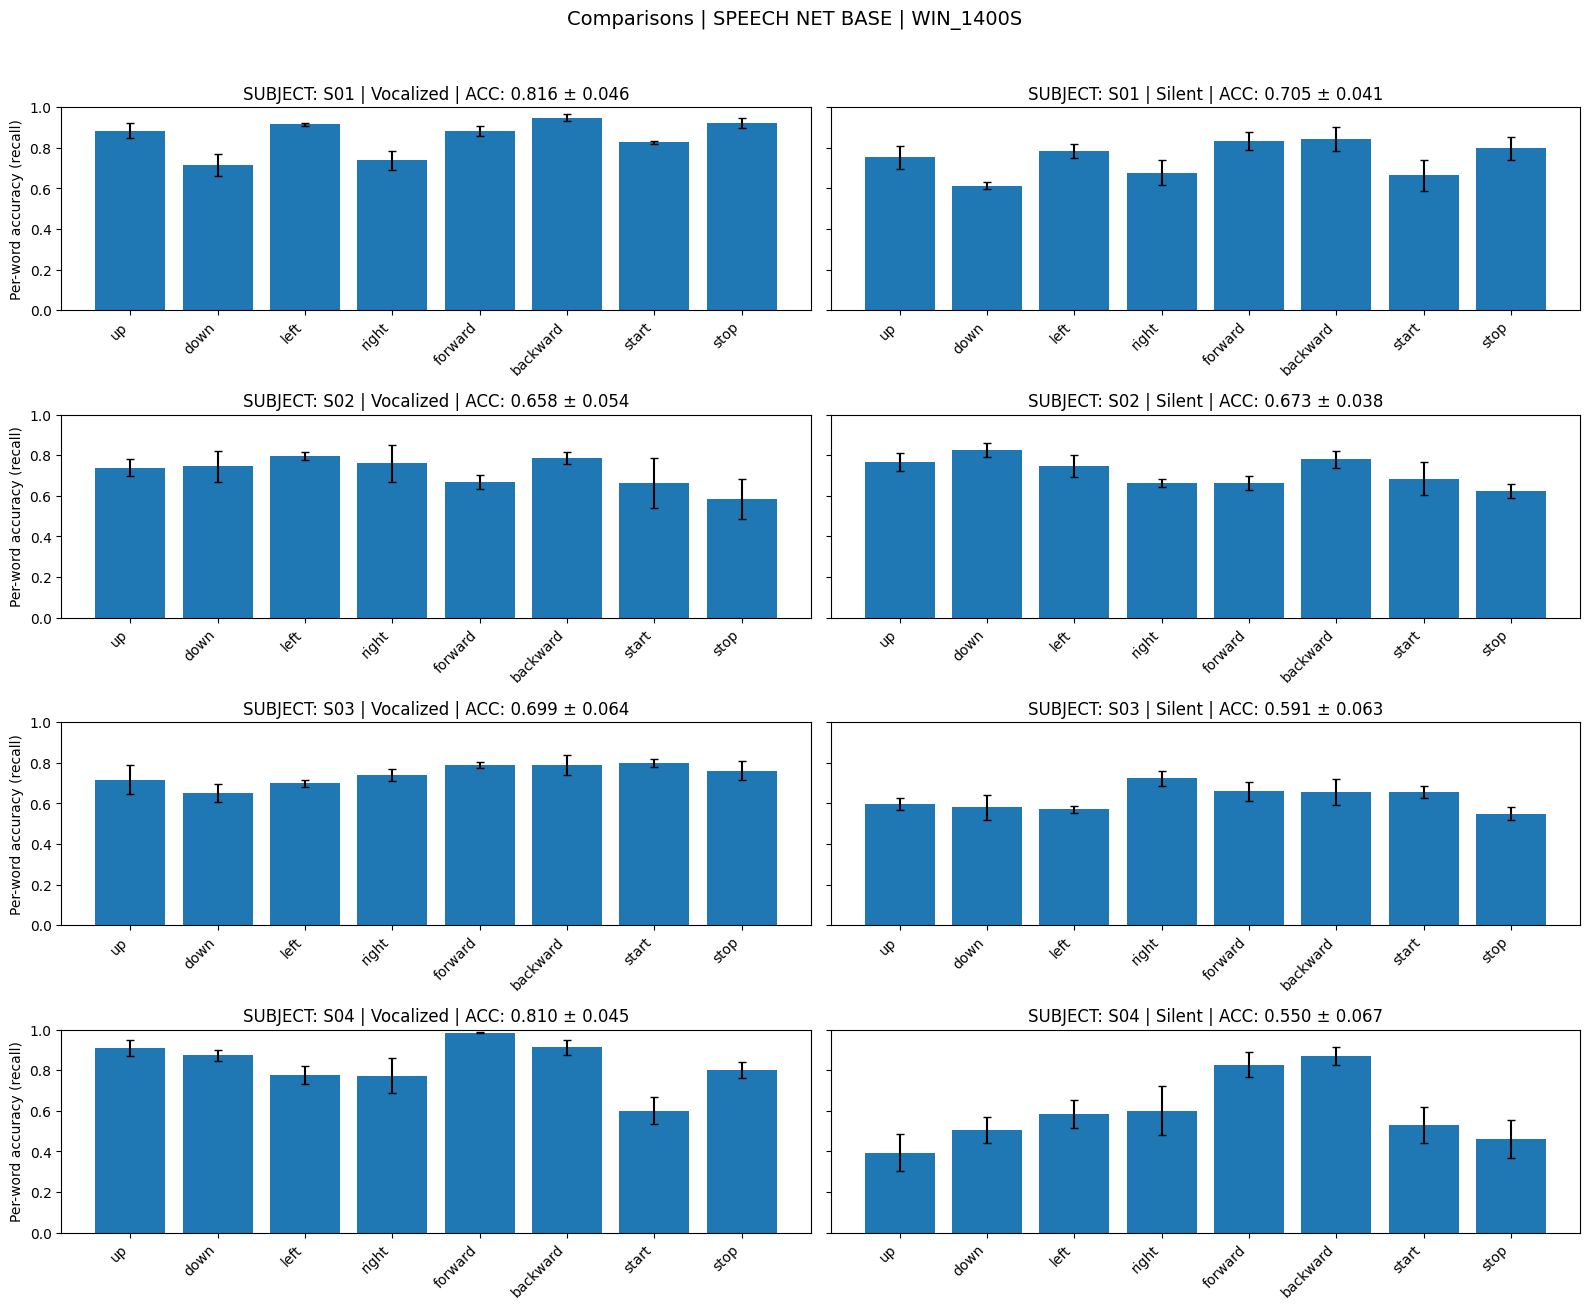

In [32]:
model_df = summary_df[summary_df['model_name'] == model_to_select]
model_win = model_df[model_df['win_size_ms']==1400]
plot_subject_word_accuracy_grid_from_summary(model_win, "vocalized", "silent", title_extras="SPEECH NET BASE | WIN_1400S")

In [33]:
silent_accs = model_win[model_win['condition'] == 'silent']['balanced_acc_mean'].values
print(f"Silent ACC | avg across subjects: {np.mean(silent_accs):.2f} ± {np.std(silent_accs):.2f}")
vocalized_accs = model_win[model_win['condition'] == 'vocalized']['balanced_acc_mean'].values
print(f"Vocalized ACC | avg across subjects: {np.mean(vocalized_accs):.2f} ± {np.std(vocalized_accs):.2f}")

Silent ACC | avg across subjects: 0.67 ± 0.07
Vocalized ACC | avg across subjects: 0.79 ± 0.06


In [35]:
model_name = "speechnet_base_hparam_abl"
if "_hparam_abl" in model_name:
    model_name = model_name.split("_hparam_abl")[0]

In [36]:
model_name

'speechnet_base'